In [8]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
from scipy import optimize
from autograd import jacobian, grad
import pandas as pd

In [9]:
eps = 0.001
delta = np.random.randint(1, 100) / 100

alpha = np.random.randint(1, 100) / 100
betta = np.random.randint(1, 100) / 100

k = np.array(list(range(0, 101)))
X = np.array(list(map(lambda x: x/100, k)))
Y= np.array([alpha*x + betta + np.random.normal(0, 1) 
               for i, x in enumerate(X)])

f_lin = lambda x, point: point[0] * x + point[1]
f_rat = lambda x, point: point[0] / (1 + point[1] * x)

D = lambda args: sum([(args[0](x, args[1]) - y) ** 2 for x, y in zip(X, Y)])

D_fun_linear   = lambda args: D((f_lin, args))
D_fun_rational = lambda args: D((f_rat, args))

In [10]:
results_lin = pd.DataFrame()
results_lin['Algorithm name'] = ['Gradient descent', 'Conjugate gradient descent', 'Newton\'s method', 'Levenberg-Marquardt algorithm', '*Exhaustive search', '*Gauss method', '*Nelder-Mead']
results_lin.set_index('Algorithm name', inplace=True)
results_lin.style.set_caption("Results of linear approximation")

header_list = ['Number of iters', 'Function min', 'Number of func calculations']
results_lin = results_lin.reindex(columns = header_list) 

In [11]:
results_rat = pd.DataFrame()
algs = ['Gradient descent', 'Conjugate gradient descent', 'Newton\'s method', 'Levenberg-Marquardt algorithm', '*Exhaustive search', '*Gauss method', '*Nelder-Mead']
results_rat['Algorithm name'] = algs
results_rat.set_index('Algorithm name', inplace=True)
results_rat.style.set_caption("Results of rational approximation")

header_list = ['Number of iters', 'Function min', 'Number of func calculations']
results_rat = results_lin.reindex(columns = header_list) 

## Gradient descent

In [12]:
def golden_section(f, a, b, eps=eps):
    x1 = a + (3 - 5**0.5)*(b - a)/2
    x2 = b + (5**0.5 - 3)*(b - a)/2
    i = 0
    f1 = f(x1)
    f2 = f(x2)
    while np.abs(a - b) >= eps:
        if f(x1) <= f(x2):
            b = x2
            x2 = x1
            x1 = a + (3 - np.sqrt(5))/2*(b - a)
            f2 = f1
            f1 = f(x1)
        else:
            a = x1
            x1 = x2
            x2 = b + (np.sqrt(5) - 3)/2*(b - a)
            f1 = f2
            f2 = f(x2)
        i += 1
    return (a+b)/2, i + 2, i

In [13]:
def gradient_descent(f, args):
    f_min_previous = f(args)
    args = np.random.randint(1, 100) / 100, np.random.randint(1, 100) / 100
    f_min = f(args)
    i = 0
    while np.abs(f_min - f_min_previous) > eps:
        f_min_previous = f_min
        gradient = grad(f)

        def one_dim_step(h):
            return f(args - h * np.array(gradient(args)))
        
        h = golden_section(one_dim_step, 0, 1)[0]
        args = args - h * np.array(gradient(args))
        f_min = f(args - h * np.array(gradient(args)))
        i += 1
    return args[0], args[1], f_min, i+2, i

In [14]:
%%time
grad_lin_res = gradient_descent(D_fun_linear, [0, 0])
grad_lin_res

CPU times: user 9.62 s, sys: 131 ms, total: 9.75 s
Wall time: 9.57 s


In [15]:
num_of_iterations, func_value, func_count = grad_lin_res[3], round(grad_lin_res[2], 3), grad_lin_res[4]
results_lin.loc[algs[0], :] = [num_of_iterations, func_value, func_count]

In [16]:
%%time
grad_rat_res = gradient_descent(D_fun_rational, [0, 0])
grad_rat_res

CPU times: user 13.4 s, sys: 116 ms, total: 13.6 s
Wall time: 13.5 s


In [17]:
num_of_iterations, func_value, func_count = grad_rat_res[3], round(grad_rat_res[2], 3), grad_rat_res[4]
results_rat.loc[algs[0], :] = [num_of_iterations, func_value, func_count]

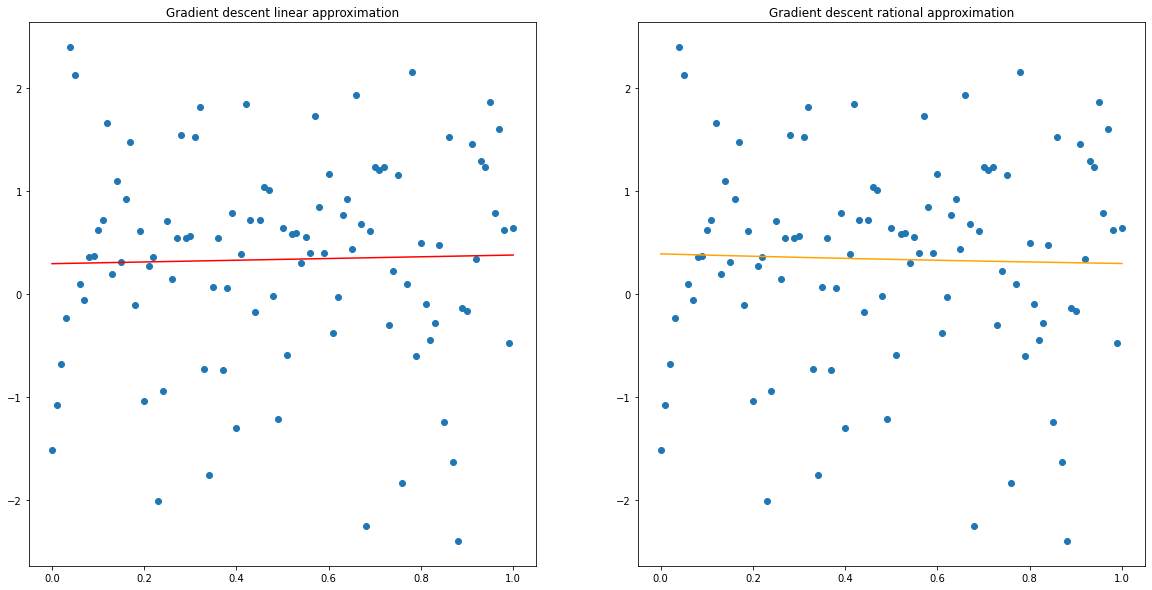

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes.flat[0].plot(X, f_lin(X, (grad_lin_res[0], grad_lin_res[1])), color='red')
axes.flat[0].scatter(X, Y)
axes.flat[0].set_title('Gradient descent linear approximation')

axes.flat[1].plot(X, f_rat(X, (grad_rat_res[0], grad_rat_res[1])), color='orange')
axes.flat[1].scatter(X, Y)
axes.flat[1].set_title('Gradient descent rational approximation');

## Conjugate Gradient descent

In [19]:
cg_lin_res = optimize.minimize(D_fun_linear, np.random.rand(2), method='CG', tol=0.001)
cg_lin_res

     fun: 101.40414728902289
     jac: array([-5.72204590e-06, -9.53674316e-07])
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 2
    njev: 6
  status: 0
 success: True
       x: array([0.08306408, 0.29523403])

In [20]:
num_of_iterations, func_value, func_count = cg_lin_res.nit, round(cg_lin_res.fun, 3), cg_lin_res.nfev
results_lin.loc[algs[1], :] = [num_of_iterations, func_value, func_count]

In [21]:
cg_rat_res = optimize.minimize(D_fun_rational, np.random.rand(2), method='CG', tol=0.001)
cg_rat_res

     fun: 101.40396425263755
     jac: array([-4.38690186e-05,  2.28881836e-05])
 message: 'Optimization terminated successfully.'
    nfev: 72
     nit: 8
    njev: 18
  status: 0
 success: True
       x: array([ 0.29781164, -0.22175293])

In [22]:
num_of_iterations, func_value, func_count = cg_rat_res.nit, round(cg_rat_res.fun, 3), cg_rat_res.nfev
results_rat.loc[algs[1], :] = [num_of_iterations, func_value, func_count]

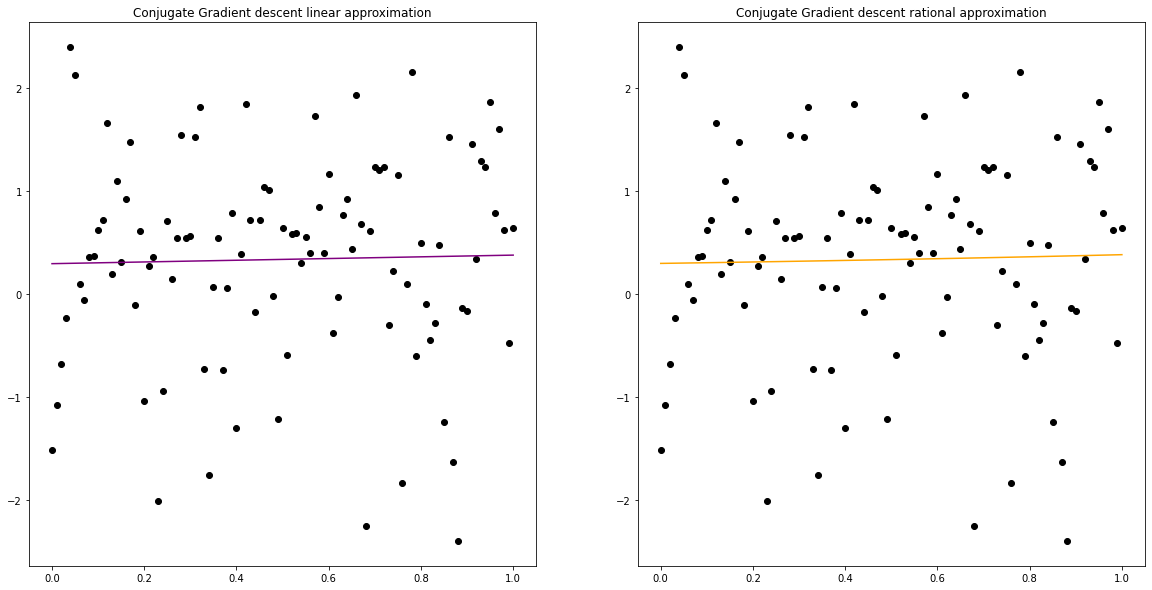

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes.flat[0].plot(X, f_lin(X, cg_lin_res.x), color='purple')
axes.flat[0].scatter(X, Y, color='k')
axes.flat[0].set_title('Conjugate Gradient descent linear approximation')

axes.flat[1].plot(X, f_rat(X, cg_rat_res.x), color='orange')
axes.flat[1].scatter(X, Y, color='k')
axes.flat[1].set_title('Conjugate Gradient descent rational approximation');

## Newton's method

In [24]:
ncg_lin_res = optimize.minimize(D_fun_linear, np.random.rand(2),jac=jacobian(D_fun_linear), 
                       method='Newton-CG', tol=0.001)
ncg_lin_res

     fun: 101.40414728902249
     jac: array([9.23978630e-09, 1.30565105e-08])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 46
    nhev: 0
     nit: 3
    njev: 52
  status: 2
 success: False
       x: array([0.08306428, 0.29523392])

In [25]:
num_of_iterations, func_value, func_count = ncg_lin_res.nit, round(ncg_lin_res.fun, 3), ncg_lin_res.nfev
results_lin.loc[algs[2], :] = [num_of_iterations, func_value, func_count]

In [26]:
ncg_rat_res = optimize.minimize(D_fun_rational, np.random.rand(2),jac=jacobian(D_fun_rational), 
                       method='Newton-CG', tol=0.001)
ncg_rat_res

     fun: 101.40396425262846
     jac: array([ 0.01520278, -0.00668315])
 message: 'Optimization terminated successfully.'
    nfev: 13
    nhev: 0
     nit: 8
    njev: 48
  status: 0
 success: True
       x: array([ 0.29781043, -0.22176131])

In [27]:
num_of_iterations, func_value, func_count = ncg_rat_res.nit, round(ncg_rat_res.fun, 3), ncg_rat_res.nfev
results_rat.loc[algs[2], :] = [num_of_iterations, func_value, func_count]

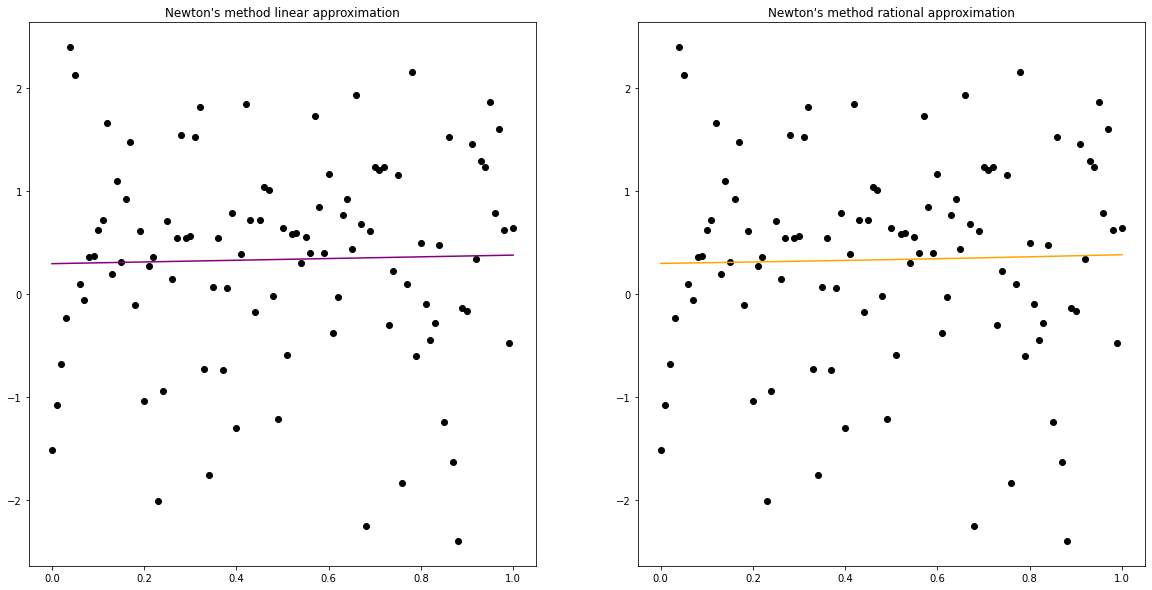

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes.flat[0].plot(X, f_lin(X, ncg_lin_res.x), color='purple')
axes.flat[0].scatter(X, Y, color='k')
axes.flat[0].set_title('Newton\'s method linear approximation')

axes.flat[1].plot(X, f_rat(X, ncg_rat_res.x), color='orange')
axes.flat[1].scatter(X, Y, color='k')
axes.flat[1].set_title('Newton\'s method rational approximation');

## Levenberg-Marquardt algorithm

In [29]:
f_lin_ = lambda args, x, y: args[0] * x + args[1] - y
f_rat_ = lambda args, x, y: args[0] / (1 + args[1] * x) - y

In [30]:
lm_lin_res = optimize.least_squares(f_lin_, np.random.rand(2), args=(X, Y), method='lm')

In [31]:
num_of_iterations, func_value, func_count = '-', round(D_fun_linear(lm_lin_res.x), 3), lm_lin_res.nfev
results_lin.loc[algs[3], :] = [num_of_iterations, func_value, func_count]

In [32]:
lm_rat_res = optimize.least_squares(f_rat_, np.random.rand(2), args=(X, Y), method='lm')

In [33]:
num_of_iterations, func_value, func_count = '-', round(D_fun_linear(lm_rat_res.x), 3), lm_rat_res.nfev
results_rat.loc[algs[3], :] = [num_of_iterations, func_value, func_count]

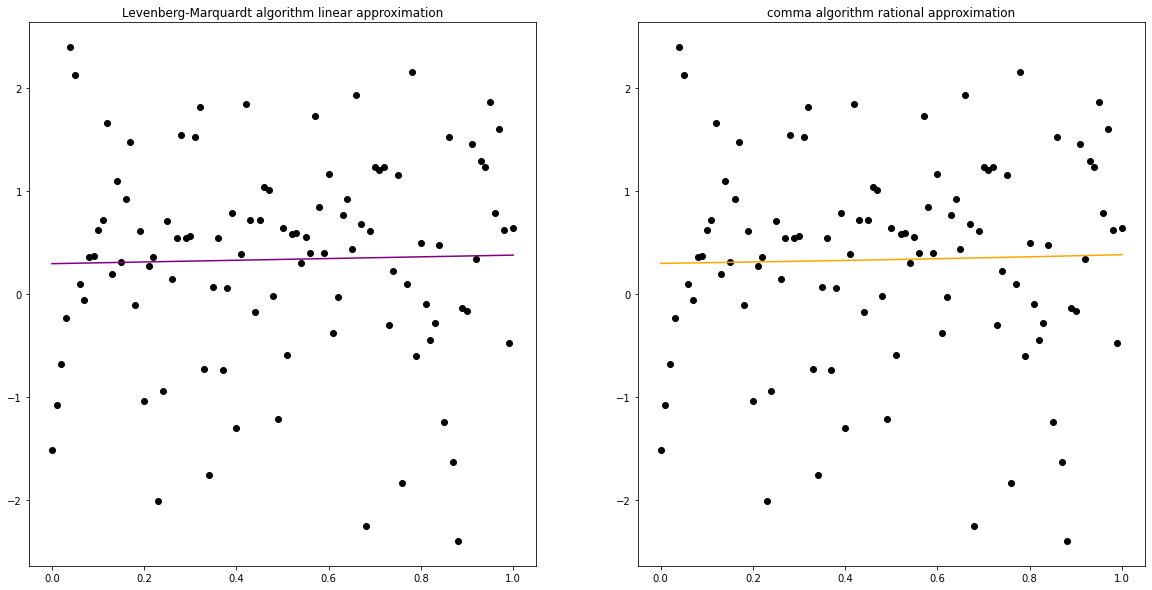

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes.flat[0].plot(X, f_lin(X, lm_lin_res.x), color='purple')
axes.flat[0].scatter(X, Y, color='k')
axes.flat[0].set_title('Levenberg-Marquardt algorithm linear approximation')

axes.flat[1].plot(X, f_rat(X, lm_rat_res.x), color='orange')
axes.flat[1].scatter(X, Y, color='k')
axes.flat[1].set_title('comma algorithm rational approximation');

# Lab 2 algorithms

In [35]:
from itertools import product

In [36]:
f_lin = lambda x, a, b: a * x + b
f_rat = lambda x, a, b: a / (1 + b * x)

D = lambda f, X, Y, a, b: sum([(f(x, a, b) - y) ** 2 for x, y in zip(X, Y)])

## Exhaustive search

In [37]:
steps = np.arange(-1, 1.001, 0.001)

def exhaustive_search_multi(f, X, Y, alpha, betta):
    f_min = D(f, X, Y, alpha, betta)
    alpha_res = 0
    betta_res = 0
    i = 0
    for alpha, betta in list(product(steps, steps)):
        curr_f = D(f, X, Y, alpha, betta)
        if curr_f < f_min:
            f_min = curr_f
            alpha_res = alpha
            betta_res = betta
        i += 1
    return [alpha_res, betta_res, f_min, i+1, i]

In [38]:
%%time
exh_lin_res = exhaustive_search_multi(f_lin, X, Y, 0, 0)
exh_lin_res

CPU times: user 7min 22s, sys: 1.59 s, total: 7min 24s
Wall time: 7min 24s


In [41]:
num_of_iterations, func_value, func_count = exh_lin_res[3], round(exh_lin_res[2], 3), exh_lin_res[-1]
results_lin.loc[algs[4], :] = [num_of_iterations, func_value, func_count]

In [42]:
%%time
exh_rat_res = exhaustive_search_multi(f_rat, X, Y, 0, 0)
exh_rat_res

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


CPU times: user 9min 33s, sys: 1.16 s, total: 9min 34s
Wall time: 9min 35s


In [43]:
num_of_iterations, func_value, func_count = exh_rat_res[3], round(exh_rat_res[2], 3), exh_rat_res[-1]
results_rat.loc[algs[4], :] = [num_of_iterations, func_value, func_count]

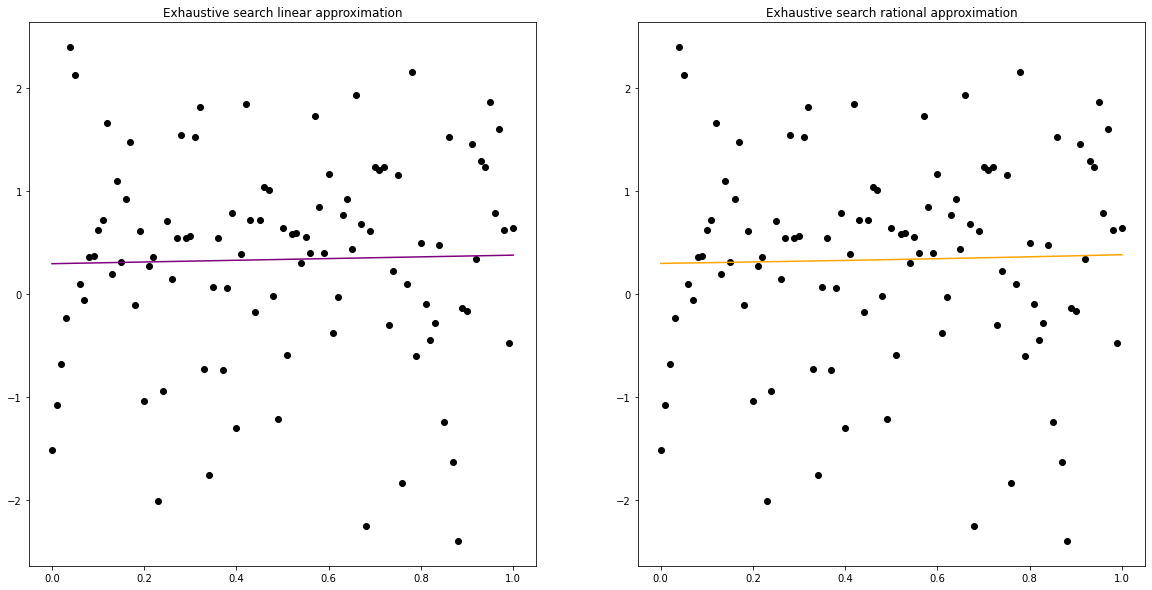

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes.flat[0].plot(X, f_lin(X, exh_lin_res[0], exh_lin_res[1]), color='purple')
axes.flat[0].scatter(X, Y, color='k')
axes.flat[0].set_title('Exhaustive search linear approximation')

axes.flat[1].plot(X, f_rat(X, exh_rat_res[0], exh_rat_res[1]), color='orange')
axes.flat[1].scatter(X, Y, color='k')
axes.flat[1].set_title('Exhaustive search rational approximation');

## Gauss method

In [45]:
# Gauss
eps = 0.001

def dichotomy_for_D(f, X, Y, a, b, a_opt, b_opt, par = 'a'):
    i = 0
    delta = np.random.uniform(0, eps)
    
    while np.abs(a - b) > eps:
        x1 = (a + b - delta) / 2
        x2 = (a + b + delta) / 2
        f_1 = D(f, X, Y, x1, b_opt) if par == 'a' else D(f, X, Y, a_opt, x1)
        f_2 = D(f, X, Y, x2, b_opt) if par == 'a' else D(f, X, Y, a_opt, x2)
        
        if f_1 <= f_2:
            b = x2
            fmin = f_1
        else:
            a = x1
            fmin = f_2
        i += 1
    return x1, i*2, i

def gauss(f, X, Y, z1 = 0, z2 = 0):
    f_min_prev = D(f, X, Y, z1, z2)
    z1_prev = z1
    z1 =  dichotomy_for_D(f, X, Y, -1, 1 + eps, z1, z2)[0]
    f_min = D(f, X, Y, z1, z2)
    i = 1 + dichotomy_for_D(f, X, Y, -1, 1 + eps, z1, z2)[2]
    j = 2 + dichotomy_for_D(f, X, Y, -1, 1 + eps, z1, z2)[1]
    l = 1
    while (np.abs(f_min - f_min_prev) >= eps) and (np.abs(z1 - z1_prev) >= eps):
      if l % 2 == 0:
          z1_prev = z1
          z1 =  dichotomy_for_D(f, X, Y, -1, 1 + eps, z1, z2)[0]
          f_min_prev = f_min
          f_min = D(f, X, Y, z1, z2)
          i += 1 + dichotomy_for_D(f, X, Y, -1, 1 + eps, z1, z2)[2]
          j += 1 + dichotomy_for_D(f, X, Y, -1, 1 + eps, z1, z2)[1]
      else:
          z2_prev = z2
          z2 =  dichotomy_for_D(f, X, Y, -1, 1 + eps, z1, z2, par = 'b')[0]
          f_min_prev = f_min
          f_min = D(f, X, Y, z1, z2)
          i += 1 + dichotomy_for_D(f, X, Y, -1, 1 + eps, z1, z2, par = 'b')[2]
          j += 1 + dichotomy_for_D(f, X, Y, -1, 1 + eps, z1, z2, par = 'b')[1]
          if np.abs(z2 - z2_prev) < eps:
              break
      l += 1
    return z1, z2, j, i


In [48]:
%%time
F_linear_opt_2 = gauss(f_lin, X, Y, alpha, betta)

CPU times: user 22.4 ms, sys: 0 ns, total: 22.4 ms
Wall time: 22.8 ms


In [49]:
num_of_iterations, func_value, func_count = F_linear_opt_2[3], round(D(f_lin, X, Y, F_linear_opt_2[0], F_linear_opt_2[1]), 3), F_linear_opt_2[-1]
results_lin.loc[algs[5], :] = [num_of_iterations, func_value, func_count]

In [50]:
%%time
F_rational_opt_2 = gauss(f_rat, X, Y, alpha, betta)

CPU times: user 214 ms, sys: 998 µs, total: 215 ms
Wall time: 218 ms


In [51]:
num_of_iterations, func_value, func_count = F_rational_opt_2[3], round(D(f_lin, X, Y, F_rational_opt_2[0], F_rational_opt_2[1]), 3), F_rational_opt_2[-1]
results_rat.loc[algs[5], :] = [num_of_iterations, func_value, func_count]

Text(0.5, 1.0, 'Gauss method rational approximation')

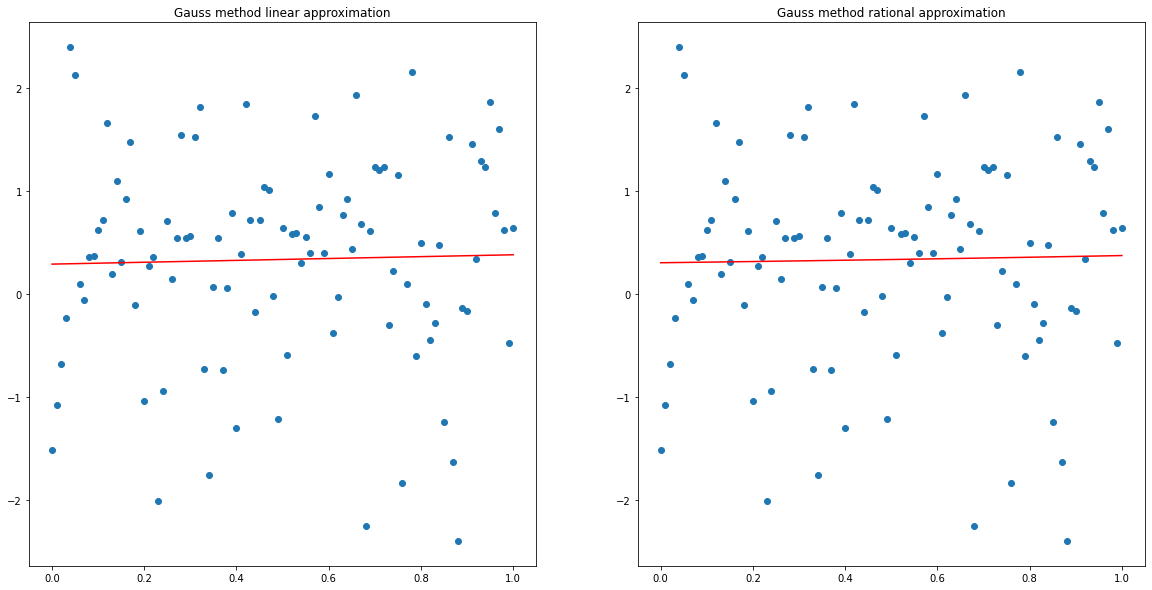

In [54]:
# Gauss method

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes.flat[0].plot(X, f_lin(X, F_linear_opt_2[0], F_linear_opt_2[1]), color = 'red')
axes.flat[0].scatter(X, Y)
axes.flat[0].set_title('Gauss method linear approximation')


axes.flat[1].plot(X, f_rat(X, F_rational_opt_2[0], F_rational_opt_2[1]), color = 'red')
axes.flat[1].scatter(X, Y)
axes.flat[1].set_title('Gauss method rational approximation')

## Nelder-Mead

In [58]:
# Nelder-Mead

def F_linear_point(x, point):
    return point[0]*x + point[1]

def F_rational_point(x, point):
    return point[0]/(1 + point[1]*x)

def D_point(point, f, X, Y):
    return sum([(f(x_i, point) - y_i)**2 for x_i, y_i in zip(X, Y)])


def nelder_mead(f, X, Y):
    result = optimize.minimize(D_point, np.random.rand(2), args=(f, X, Y), method ='nelder-mead')
    return result
    '''
    i = 0
    a = np.array([np.random.uniform(-1, eps), np.random.uniform(-1, eps), np.random.uniform(-1, eps)])
    b = np.array([np.random.uniform(-1, eps), np.random.uniform(-1, eps), np.random.uniform(-1, eps)])
    while True:
        f =np.array([D(f, X, Y, a[0], b[0]), D(f, X, Y, a[1], b[1]), D(f, X, Y, a[2], b[2])])
        f_l, f_g, f_h  = np.sort(f)[0], np.sort(f)[1], np.sort(f)[2]
        h, g, l = np.where(np.isclose(f, f_h)), np.where(np.isclose(f, f_g)), np.where(np.isclose(f, f_l))
        x_h = (a[h], b[h])
        x_c = ((a[g]+ a[l])/2, (b[g] + b[l])/2)
        x_r = (1 + alpha)*x_c - alpha*(a[h], b[h])
        f_r = D(f, X, Y, x_r[0], x_r[1])
        if f_r < f[2]:
            x_e = (1 - gamma)*x_c + gamma*x_r
            f_e = D(f, X, Y, x_e[0], x_e[1])
            if f_e < f_r:
                x_h = x_e
            else:
                x_h = x_r
        elif f[l] < f_r and f_r < f[g]:
            x_h = x_r
        elif f[g] < f_r and f_r < f[h]:
            x, y = x_r, f_r
            x_r, f_r = x_h, f[h]
            x_h, f[h] = x, y
        
        x_s = beta*x_h + (1 - beta)*x_c
        f_s = D(f, X, Y, x_s[0], x_s[1])
        if f_s < f[h]:
            x_h = x_s
    '''
        




In [59]:
%%time
F_linear_opt_3 = nelder_mead(F_linear_point, X, Y)

CPU times: user 13.7 ms, sys: 999 µs, total: 14.7 ms
Wall time: 14.9 ms


In [61]:
num_of_iterations, func_value, func_count = F_linear_opt_3.nit, round(F_linear_opt_3.fun, 3), F_linear_opt_3.nfev
results_lin.loc[algs[6], :] = [num_of_iterations, func_value, func_count]

In [62]:
%%time
F_rational_opt_3 = nelder_mead(F_rational_point, X, Y)

CPU times: user 24.2 ms, sys: 0 ns, total: 24.2 ms
Wall time: 28.5 ms


In [63]:
num_of_iterations, func_value, func_count = F_rational_opt_3.nit, round(F_rational_opt_3.fun, 3), F_rational_opt_3.nfev
results_rat.loc[algs[6], :] = [num_of_iterations, func_value, func_count]

Text(0.5, 1.0, 'Nelder-Mead method rational approximation')

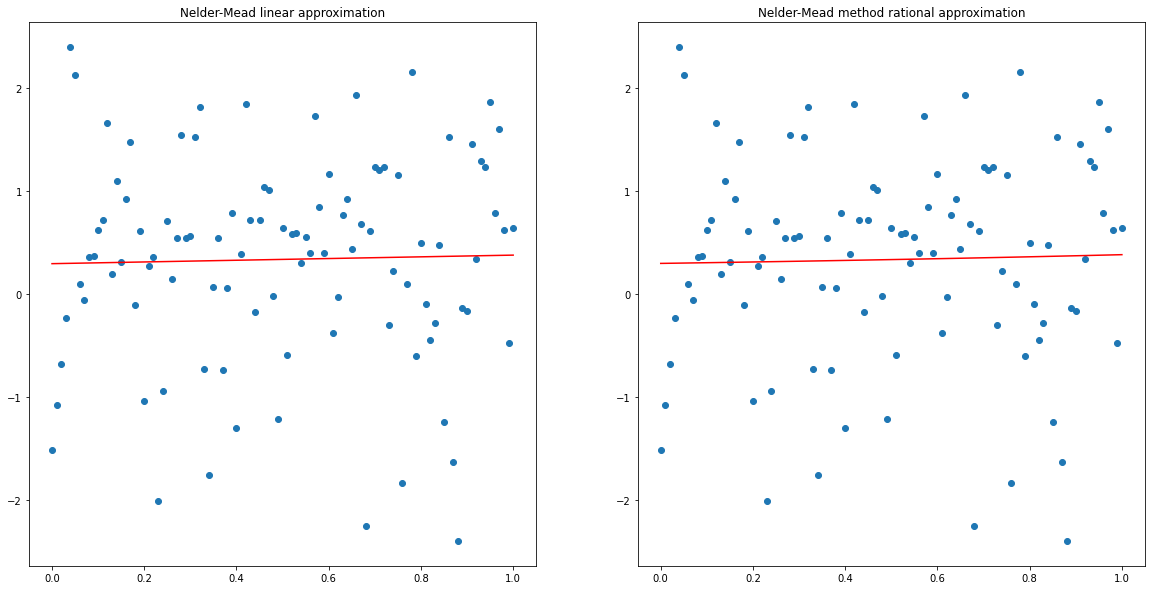

In [65]:
# Nelder-Mead

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes.flat[0].plot(X, f_lin(X, F_linear_opt_3.x[0], F_linear_opt_3.x[1]), color = 'red')
axes.flat[0].scatter(X, Y)
axes.flat[0].set_title('Nelder-Mead linear approximation')


axes.flat[1].plot(X, f_rat(X, F_rational_opt_3.x[0], F_rational_opt_3.x[1]), color = 'red')
axes.flat[1].scatter(X, Y)
axes.flat[1].set_title('Nelder-Mead method rational approximation')

# Results

In [66]:
results_lin

,Number of iters,Function min,Number of func calculations
Algorithm name,,,
Gradient descent,8,101.405,6.0
Conjugate gradient descent,2,101.404,24.0
Newton's method,3,101.404,46.0
Levenberg-Marquardt algorithm,-,101.404,7.0
*Exhaustive search,4004002,101.404,4004001.0
*Gauss method,30,101.405,30.0
*Nelder-Mead,24,101.404,47.0


In [67]:
results_rat

,Number of iters,Function min,Number of func calculations
Algorithm name,,,
Gradient descent,10,101.677,8.0
Conjugate gradient descent,8,101.404,72.0
Newton's method,8,101.404,13.0
Levenberg-Marquardt algorithm,-,118.747,20.0
*Exhaustive search,4004002,101.404,4004001.0
*Gauss method,253,115.752,253.0
*Nelder-Mead,53,101.404,102.0


In [68]:
!pip install openpyxl

In [69]:
writer = pd.ExcelWriter('results_lin.xlsx')
results_lin.to_excel(writer)
writer.save()


In [70]:
writer_ = pd.ExcelWriter('results_rat.xlsx')
results_rat.to_excel(writer_)
writer_.save()
